# **Autoencoder Using PyTorch Framework**

## Check NVIDIA GPU Setting

In [1]:
!nvidia-smi

Wed Jul  9 04:27:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load MNIST Dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [3]:
train_dataset = MNIST(root="content",
                      train=True,
                      transform=transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()]),
                      download=True)
test_dataset = MNIST(root="content",
                     train=False,
                     transform=transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()]),
                     download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


In [4]:
from torch import nn
import torch.nn.functional as F

In [5]:
class MyModel(nn.Module) :
  def __init__(self, opt) :
    super().__init__()

    input_dim, hidden_dim = opt["input_dim"], opt["hidden_dim"]

    self.encoder = nn.Sequential(nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU())
    self.decoder = nn.Sequential(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(hidden_dim, input_dim, kernel_size=3, stride=1, padding=1))

    self.bottleneck0 = nn.Linear(((opt["input_shape"]//8)**2)*hidden_dim, 2)
    self.bottleneck1 = nn.Linear(2, ((opt["input_shape"]//8)**2)*hidden_dim)

  def forward(self, input) :
    output = self.encoder(input)

    n, c, h, w = output.size()
    lnt_vec = self.bottleneck0(output.view(-1, c*h*w))

    output = self.decoder(self.bottleneck1(lnt_vec).view(n, c, h, w))

    return lnt_vec, output

## Train DL Model

In [6]:
import torch
from torch.utils.data import DataLoader
from torch import optim

from torchsummary import summary

from tqdm import tqdm

### Fix Seed

In [7]:
import random
import numpy as np

In [8]:
def fix_seed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## Create Average Meter Instance

In [9]:
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count

## Training Code as a Function (Abstraction)

In [10]:
def train(opt, train_dataset, test_dataset, MyModel, criterion) :
  fix_seed(opt["seed"])

  train_dataloader = DataLoader(train_dataset, batch_size=opt["batch_size"], shuffle=True, drop_last=True)
  test_dataloader = DataLoader(test_dataset, batch_size=opt["batch_size"], shuffle=False, drop_last=False)

  fix_seed(opt["seed"])
  model = MyModel(opt)
  if opt["cuda"] :
    model = model.cuda()

  summary(model, (opt["input_dim"], opt["input_shape"], opt["input_shape"]))

  optimizer = optim.Adam(model.parameters(), lr=opt["lr"])

  train_loss, test_loss = AverageMeter(), AverageMeter()
  train_loss_list, test_loss_list = [], []
  best_loss = torch.inf

  for epoch in range(1, opt["epochs"]+1) :
    train_bar = tqdm(train_dataloader)
    train_loss.reset()

    for data in train_bar :
      input, _ = data
      if opt["cuda"] :
        input = input.cuda()

      optimizer.zero_grad()

      pred = model(input)

      loss = criterion(pred[-1], input)
      loss.backward()

      optimizer.step()

      train_loss.update(loss.item(), opt["batch_size"])
      train_bar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Train] < Loss:{train_loss.avg:.6f} >")

    train_loss_list.append(train_loss.avg)

    test_bar = tqdm(test_dataloader)
    test_loss.reset()

    for data in test_bar :
      input, _ = data
      if opt["cuda"] :
        input = input.cuda()

      model.eval()
      with torch.no_grad() :
        pred = model(input)
        loss = criterion(pred[-1], input)

        test_loss.update(loss.item(), opt["batch_size"])

        test_bar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Test] < Loss:{test_loss.avg:.6f} >")

    test_loss_list.append(test_loss.avg)

    if test_loss.avg < best_loss :
      best_loss = test_loss.avg
      torch.save(model.state_dict(), "best_model.pth")

    torch.save(model.state_dict(), "latest_model.pth")

  return (train_loss_list, test_loss_list)

## Create Training Option (Hyperparameter) Dictionary

In [11]:
opt = {"input_shape":32,
       "seed":42,
       "input_dim":1,
       "hidden_dim":64,
       "batch_size":16,
       "lr":1e-4,
       "epochs":10,
       "cuda":torch.cuda.is_available()}

## Train Model

In [12]:
loss_list = train(opt, train_dataset, test_dataset, MyModel, nn.L1Loss())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          36,928
             ReLU-11             [-1, 64, 4, 4]               0
           Linear-12                    [-1, 2]           2,050
           Linear-13                 [-1, 1024]           3,072
           Conv2d-14             [-1, 6

[10/10] [Test] < Loss:0.073597 >: 100%|██████████| 625/625 [00:03<00:00, 178.89it/s]


## Plot Training vs. Test Loss Graph

In [13]:
import matplotlib.pyplot as plt

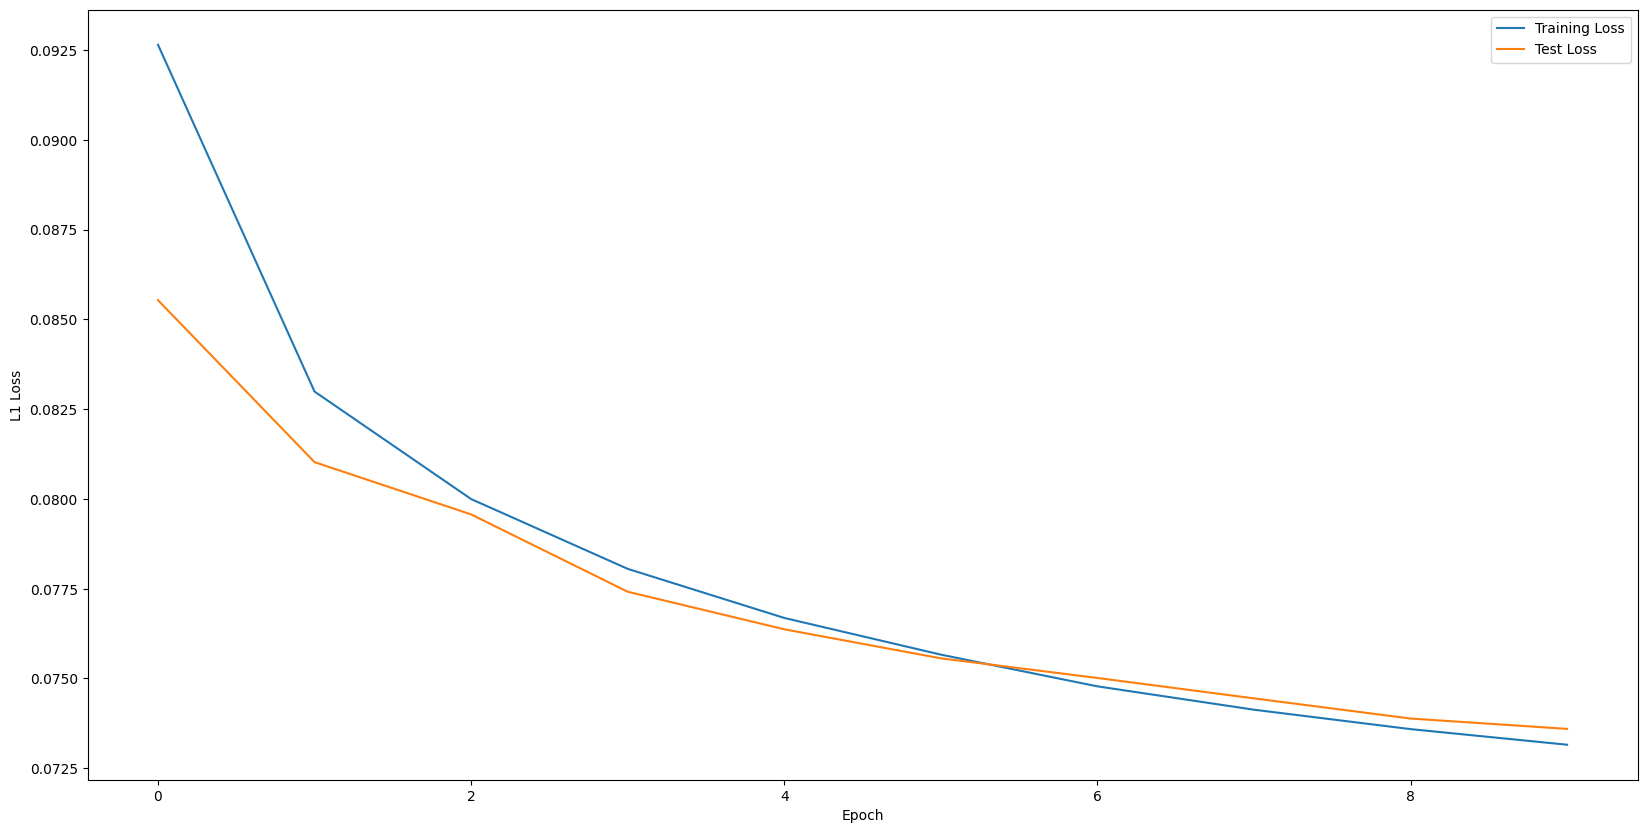

In [14]:
plt.figure(figsize=(20,10))

plt.plot(np.arange(0, opt["epochs"], 1), loss_list[0], label="Training Loss")
plt.plot(np.arange(0, opt["epochs"], 1), loss_list[1], label="Test Loss")

plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.legend(loc="best")

plt.show()

## Extract Latent Vector

### Load Trained Model

In [15]:
weights = torch.load("/content/best_model.pth")

model = MyModel(opt)
model.load_state_dict(weights)
if opt["cuda"] :
  model = model.cuda()

### Get Model Structure

In [16]:
print(model)

MyModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(64, 64, kernel_size

### Load Test Dataset

In [17]:
test_dataloader = DataLoader(test_dataset, batch_size=opt["batch_size"], shuffle=False, drop_last=False)

### Create Dictionary Instance for Saving Result

In [18]:
class_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

### Add Result

In [19]:
for input, target in test_dataloader :
  if opt["cuda"] :
    input = input.cuda()
  lnt_vec, output = model(input)

  for i, label in enumerate(target) :
    class_dict[int(label)].append(lnt_vec[i].view(-1).detach().cpu().numpy())

In [20]:
class_dict

{0: [array([ 0.1560547, -1.6045177], dtype=float32),
  array([-0.3964812, -2.257542 ], dtype=float32),
  array([-0.25880483, -1.745502  ], dtype=float32),
  array([ 0.3894296, -3.192785 ], dtype=float32),
  array([-0.12110795, -1.4855379 ], dtype=float32),
  array([ 0.04828786, -1.1302433 ], dtype=float32),
  array([-0.6785989, -4.3626747], dtype=float32),
  array([-0.48980334, -2.3775742 ], dtype=float32),
  array([-0.38829926, -2.1263783 ], dtype=float32),
  array([-1.0177486, -2.5172422], dtype=float32),
  array([-0.05399352, -1.4595706 ], dtype=float32),
  array([ 0.02640788, -1.3996807 ], dtype=float32),
  array([-0.04430075, -1.4117916 ], dtype=float32),
  array([-0.45040673, -3.626711  ], dtype=float32),
  array([ 0.08633541, -2.2843506 ], dtype=float32),
  array([ 1.1178576, -2.3130774], dtype=float32),
  array([-0.07029036, -1.6617308 ], dtype=float32),
  array([ 0.18616089, -1.4452919 ], dtype=float32),
  array([-1.5837457, -2.9870708], dtype=float32),
  array([-0.22002181, -

### Visualize Result

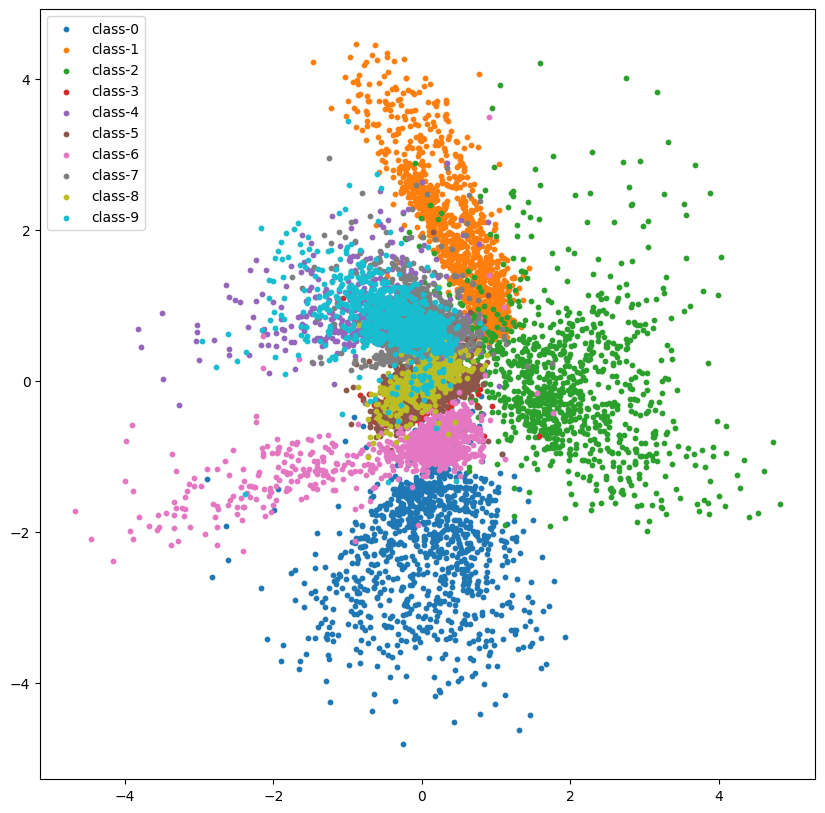

In [21]:
plt.figure(figsize=(10,10))

for i in range(10) :
  x_list, y_list = [], []
  for sub_lnt_vec in class_dict[i] :
    x_list.append(sub_lnt_vec[0])
    y_list.append(sub_lnt_vec[1])
  plt.scatter(x_list, y_list, label=f"class-{i}", s=10)

plt.legend(loc="best")
plt.show()